**This notebook is formatted to work with [Quarto](https://quarto.org/).**

**You can see the generated output using `quarto render notebook.ipynb to --html` [here](https://heatingplanet.org/absolute.html).**

In [1]:
#| echo: false
#!pip install numpy requests plotly matplotlib jupyter 
#!pip install ruptures area kaleido

import numpy as np
import plotly.graph_objects as go
from area import area
from functools import partial

from itertools import cycle
import numpy as np
from ruptures.utils import pairwise
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from IPython.display import Image

COLOR_CYCLE = ["#4286f4", "#f44174"]

class MatplotlibMissingError(RuntimeError):
    pass

def display(signal, true_chg_pts, offset_x=0, computed_chg_pts=None, **kwargs):
    """
    Adapted from the ruptures package
    
    Display a signal and the change points provided in alternating colors. If another set of change
    point is provided, they are displayed with dashed vertical dashed lines.

    Args:
        signal (array): signal array, shape (n_samples,) or (n_samples, n_features).
        true_chg_pts (list): list of change point indexes.
        computed_chg_pts (list, optional): list of change point indexes.

    Returns:
        tuple: (figure, axarr) with a :class:`matplotlib.figure.Figure` object and an array of Axes objects.

    """
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise MatplotlibMissingError(
            'This feature requires the optional dependency matpotlib, you can install it using `pip install matplotlib`.')

    if type(signal) != np.ndarray:
        # Try to get array from Pandas dataframe
        signal = signal.values

    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    n_samples, n_features = signal.shape
    # let's set all options
    figsize = (10, 2 * n_features)  # figure size
    alpha = 0.2  # transparency of the colored background
    color = "k"  # color of the lines indicating the computed_chg_pts
    linewidth = 3   # linewidth of the lines indicating the computed_chg_pts
    linestyle = "--"   # linestyle of the lines indicating the computed_chg_pts

    if "figsize" in kwargs:
        figsize = kwargs["figsize"]
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    if "color" in kwargs:
        color = kwargs["color"]
    if "linewidth" in kwargs:
        linewidth = kwargs["linewidth"]
    if "linestyle" in kwargs:
        linestyle = kwargs["linestyle"]

    fig, axarr = plt.subplots(n_features, figsize=figsize, sharex=True)
    if n_features == 1:
        axarr = [axarr]

    for axe, sig in zip(axarr, signal.T):
        color_cycle = cycle(COLOR_CYCLE)
        # plot s
        axe.plot(range(offset_x, offset_x + n_samples), sig)

        # color each (true) regime
        bkps = [0] + sorted(true_chg_pts)

        for (start, end), col in zip(pairwise(bkps), color_cycle):
            axe.axvspan(max(0, start + offset_x - 0.5),
                        end + offset_x - 0.5,
                        facecolor=col, alpha=alpha)

        # vertical lines to mark the computed_chg_pts
        if computed_chg_pts is not None:
            for bkp in computed_chg_pts:
                if bkp != 0 and bkp < n_samples:
                    axe.axvline(x=bkp + offset_x - 0.5,
                                color=color,
                                linewidth=linewidth,
                                linestyle=linestyle)

    fig.tight_layout()

    return fig, axarr

def display_plotly(signal, true_chg_pts, offset_x=0, **kwargs):
    """
    Display a signal and the change points provided in alternating colors. If another set of change
    point is provided, they are displayed with dashed vertical dashed lines.

    Args:
        signal (array): signal array, shape (n_samples,) or (n_samples, n_features).
        true_chg_pts (list): list of change point indexes.
        computed_chg_pts (list, optional): list of change point indexes.

    Returns:
        tuple: (figure, axarr) with a :class:`matplotlib.figure.Figure` object and an array of Axes objects.

    """
    n_samples = len(signal)
    alpha = 0.2
    color = '#1f77b4'

    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    if "color" in kwargs:
        color = kwargs["color"]

    fig = go.Figure(data=[go.Scatter(x=np.arange(offset_x, offset_x + n_samples), y=signal, mode='lines+markers', marker_color=color, name='Measured')])

    color_cycle = cycle(COLOR_CYCLE)

    # color each (true) regime
    bkps = [0] + sorted(true_chg_pts)

    for (start, end), col in zip(pairwise(bkps), color_cycle):
        fig.add_vrect(x0=max(0, start + offset_x - 0.5), x1=end + offset_x - 0.5, fillcolor=col, opacity=alpha, layer="below", line_width=0)

    return fig

def make_pid(coord1, coord2):
    long1, lat1 = coord1
    long2, lat2 = coord2
    pid = "{:03d}{}{:03d}{} - {:03d}{}{:03d}{}".format(
       int(np.abs(lat1)), 'N' if lat1 >= 0 else 'S',
       int(np.abs(long1)), 'E' if long1 >= 0 else 'W',
       int(np.abs(lat2)), 'N' if lat2 >= 0 else 'S',
       int(np.abs(long2)), 'E' if long2 >= 0 else 'W',
    )
    return pid

def make_feature(polygon):
    pid = make_pid(polygon[0], polygon[2])
    return {'type': 'Feature',
            'geometry': {'type': 'Polygon',
                         'coordinates': [polygon.tolist()]},
            'id': pid}

def make_geojson(polygons):
    features = list(map(make_feature, polygons.reshape(-1, 5, 2)))
    cells = {'type': 'FeatureCollection',
             'features': features}
    return cells

def surface_pids(polygons):
    pids = np.array(list(map(lambda p: make_pid(p[0], p[2]), polygons.reshape(-1, 5, 2)))).reshape(polygons.shape[0], -1)
    return pids

def make_polygon(coords, size):
    left_long, bottom_lat = coords
    return np.array([[[left_long, bottom_lat],
                      [left_long, bottom_lat + size],
                      [left_long + size, bottom_lat + size],
                      [left_long + size, bottom_lat],
                      [left_long, bottom_lat]]], dtype=np.float32)

def surface_polygons(grid_size=5):
    long, lat = np.meshgrid(np.arange(-180, 180, grid_size), 
                            np.arange(90-grid_size, -90-grid_size, -grid_size))
    coords = np.dstack([long, lat])
    polygons = np.apply_along_axis(func1d=partial(make_polygon, size=grid_size), 
                                   axis=2, arr=coords)
    return polygons

def surface_area(polygons, perc=True):
    meridian_surface_area = np.array(list(map(area, 
                            map(lambda c: {'type': 'Polygon', 'coordinates': c.tolist()}, 
                            polygons[:, 0]))))/1e6
    surface_area = np.tile(meridian_surface_area.reshape(-1, 1), polygons.shape[1])
    surface_perc = (surface_area / surface_area.sum())
    return surface_perc if perc else surface_area

def add_base(fig, start_base, end_base):
    fig.add_shape(type="line",
                  x0=start_base, y0=0, x1=end_base, y1=0,
                  line=dict(color="LightSeaGreen", width=4, dash="dashdot"))

    fig.add_vrect(x0=start_base, x1=end_base, fillcolor='rgb(184, 247, 212)', opacity=0.5, layer="below", line_width=0)
    return fig

def plot_projection(values, pids=None, label='Year', seq_offset=1880, add_line=True, animate=False,
                    colorscale='BlueRed', opacity=0.5, projection='mollweide', showgrid=False, **kwargs):
    polygons = surface_polygons(5)
    cells = make_geojson(polygons)
    if pids is None:
        pids = surface_pids(polygons)

    values = values.reshape(-1, 2592)
    values = np.atleast_2d(values)
    if values.shape[0] == 1:
        animate = False
        add_line = False

    data = []
    for i in range(values.shape[0]):
        data.append(go.Choropleth(locations=pids.reshape(-1,),
                                  z=values[i].reshape(-1,).round(4),
                                  colorscale=colorscale,
                                  autocolorscale=False,
                                  geojson=cells,
                                  marker=dict(opacity=opacity, line=dict(width=0)),
                                  visible=(i == 0) | animate,
                                  **kwargs))
    layout = dict(margin={"r": 0, "t": 0, "l": 0, "b": 0},
                  geo=dict(showframe=False, showlakes=False, showcountries=True, domain={'y': [(0.2*add_line), 1.0]}, 
                           lataxis={'showgrid': showgrid, 'dtick': 5, 'gridcolor': 'black'}, 
                           lonaxis={'showgrid': showgrid, 'dtick': 5, 'gridcolor': 'black'}, 
                           projection=go.layout.geo.Projection(type=projection),))

    line_data = []
    if add_line:
        layout.update(dict(xaxis1={'domain': [.005+0.1*animate, .995], 'range': [seq_offset-.1, seq_offset-.9+values.shape[0]]},
                           yaxis1={'domain': [0.025, 0.15], 'range': [-1.2, 1.2], 'title': 'Anomaly (oC)'},),)
        surface_perc = surface_area(polygons, perc=True).reshape(1, -1)
        temps = [np.nansum(v * surface_perc) / (~np.isnan(v) * surface_perc).sum() for v in values]
        for i in range(len(temps)):
            line_data.append(go.Scatter(x=np.arange(len(temps)) + seq_offset,
                                        y=np.concatenate([temps[:i + 1], [np.nan] * (len(temps) - i)]).round(4),
                                        mode='lines+markers',
                                        xaxis='x1',
                                        yaxis='y1',
                                        visible=(i == 0) | animate))

    if not animate:
        if len(data) == 1:
            if add_line:
                data = [data[0], line_data[0]]
        else:
            steps = []
            for i in range(len(data)):
                step = dict(method='restyle',
                            args=[{'visible': [False] * (len(data)*(1 + add_line))}],# + [True]}],
                            label='{} {}'.format(label, i + seq_offset))
                step['args'][0]['visible'][i] = True
                if add_line:
                    step['args'][0]['visible'][i+len(data)] = True
                steps.append(step)

            data.extend(line_data)

            sliders = [dict(active=0, pad={"t": 0.3}, steps=steps)]
            layout.update(dict(sliders=sliders))

        fig = go.Figure(data=data, layout=layout)
    else:
        menus = [dict(buttons=[dict(args=[None, dict(frame={'duration': 500, 'redraw': True},
                                                     fromcurrent=True,
                                                     transition={'duration': 300, 'easing': 'quadratic-in-out'})],
                                    label="Play",
                                    method="animate"),
                                 dict(args=[[None], dict(frame={'duration': 0, 'redraw': True},
                                                         fromcurrent=True,
                                                         mode='immediate',
                                                         transition={'duration': 0})],
                                      label="Pause",
                                      method="animate")],
                      direction="left",
                      pad={"r": 10, "t": 25},
                      showactive=False,
                      type="buttons",
                      x=0.1, y=0,
                      xanchor="right", yanchor="top")]

        steps = []
        for i in range(len(data)):
            step = dict(method='animate',
                        args=[[i+seq_offset], dict(frame={'duration': 300, 'redraw': True},
                                                   mode='immediate',
                                                   transition={'duration': 300})],
                        label=i+seq_offset)
            steps.append(step)

        sliders = [dict(active=0,
                        yanchor="top", xanchor="left",
                        currentvalue={'prefix': 'Year ', 'visible': True, 'xanchor': 'right'},
                        transition={'duration': 300, 'easing': 'cubic-in-out'},
                        pad={"t": 0.3},
                        len=0.9, x=0.1, y=0,
                        steps=steps)]

        layout.update(dict(hovermode="closest", updatemenus=menus, sliders=sliders))
        frames = [go.Frame({'data': [d] + ([line_data[i]] if add_line else []), 'traces': [0, 1], 'name': str(i+seq_offset)})
                  for i, d in enumerate(data)]
        fig = go.Figure(data=[data[0]] + ([line_data[0]] if add_line else []), layout=layout, frames=frames)

    return fig


def plot_evolution(gridded, gy, gx, regime=None, changes=None, filled=None, extended=None, first_year=1880, start_base=1971, end_base=2000):
    polygons = surface_polygons(grid_size=5)
    pids = surface_pids(polygons)

    signal = gridded[:, gy, gx].copy()
    years = np.arange(first_year, first_year + len(signal))

    if filled is not None:
        new_signal = filled[:, gy, gx]
    if changes is not None:
        breaks, averages = changes[gy][gx]
    else:
        breaks = []
    if (regime is not None) and (changes is not None):
        avg_series = regime[:, gy, gx] + averages[0]
    if extended is not None:
        ext_signal = extended[:, gy, gx]

    layout = go.Layout(
        title={
            'text': 'Location: {}'.format(pids[gy, gx]),
            'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
        legend=dict(
            yanchor="top", y=0.99,
            xanchor="left", x=0.01),
        plot_bgcolor="#FFF",
        xaxis=dict(showgrid=False),
        yaxis=dict(
            title='Temperature Anomaly (oC) - Base {}-{}'.format(start_base, end_base),
            range=[-4, 4],
            showgrid=False,
        )
    )
    fig = display_plotly(signal, breaks, offset_x=first_year)
    if (regime is not None) and (changes is not None):
        fig.add_trace(go.Scatter(x=years, y=avg_series, marker_color='black', line=dict(dash='dash'), showlegend=False, name='Regime'))
    if filled is not None:
        fig.add_trace(go.Scatter(x=years[np.isnan(signal)], y=new_signal[np.isnan(signal)], marker_color='red', mode='markers', name='Imputed'))
    if extended is not None:
        fig.add_trace(go.Scatter(x=years[np.isnan(signal)], y=ext_signal[np.isnan(signal)], marker_color='green', mode='markers', marker_symbol='cross', name='Estimated'))
    fig.update_layout(layout)
    return fig

def plot_avg(avg_temp, start=1971, end=2000, ax=None, c='k'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))    
    baseline = np.mean(avg_temp[start-1880:end-1880+1])
    ax.plot(np.arange(1880, 1880+avg_temp.shape[0]), avg_temp-baseline, c='r', label='Average Anomaly')
    ax.plot([start, end], [0, 0], linestyle='--', c=c, label='Baseline')
    ax.plot([start, start], [-1, 1], c=c, linewidth=1)
    ax.plot([end, end], [-1, 1], c=c, linewidth=1)
    ax.set_title(f'Anomaly (oC) - Baseline: {start}-{end}')
    ax.set_ylabel('Temperature Anomaly (oC)')
    ax.set_ylim([-1, 1])
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')    
    ax.legend()

def plot_avg2(avg_temp, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))    
    ax.plot(np.arange(1880, 1880+avg_temp.shape[0]), avg_temp, c='r', label='Absolute Change')
    ax.set_title(f'Absolute Change (oC)')
    ax.set_ylabel('Absolute Change in Temperature (oC)')
    ax.set_ylim([-.5, 1.5])
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.legend()


# Motivation

I was always a bit annoyed by the arbitrary choice of a baseline to compute the average temperature anomaly. Of course, I know that the plot itself doesn't change, and a different baseline only shifts the vertical axis, since the *zero* depends on the time span used as baseline.

Still, not everyone can see through it easily. I always thought it was a disservice to people trying to learn more about global warming since it burdens the reader. 

Even worse, the NOAA's website makes it very confusing even for seasoned professionals when it mentions, literally, **four** different spans to refer to the same data!

In the page corresponding to the data we're using here, the [GHCN Gridded Products](https://www.ncei.noaa.gov/access/monitoring/ghcn-gridded-products/), we see:

- 1991 to 2020 in [Maps](https://www.ncei.noaa.gov/access/monitoring/ghcn-gridded-products/)
- 1961 to 1990, and 1981 to 2010 in [Data Set Development](https://www.ncei.noaa.gov/access/monitoring/ghcn-gridded-products/development)
- 1971 to 2000 in [Data Access](https://www.ncei.noaa.gov/access/monitoring/ghcn-gridded-products/data-access), the one the data is actually adjusted to

Moreover, given the very nature of the dataset, NOAA recommends in the [Note](https://www.ncei.noaa.gov/access/monitoring/ghcn-gridded-products/note) section:

>  "These gridded data sets were developed to produce the most accurate time series possible. However, this required that months and grid boxes be treated independently through time. The use of these data sets is most appropriate for analyzing the change in temperature within a particular grid box, or set of grid boxes, over a span of years."

::: {.callout-tip}
It makes sense, since different locations exhibit quite different weather and temperature patterns, and *worse yet*, they are being impacted by global warming differently over time.
:::

The only reasonable way to compare them, and aggregate them, is to try to find their own **baselines**. 

::: {.callout-tip}
The **baseline** represents the **typical temperature pattern in a given location before it was modified/disturbed by the effects of global warming**. 

Regardless of the time span used to compute the temperature anomalies, it should be possible to find out which (relative) temperature was *typical* of a given location for a certain period of time. 

Once this temperature level was established, we can look for **change points** corresponding to a regime change in the temperature. 
:::


The (relative) temperature in the changed regime, when compared to the baseline (the first observed regime) gives us an indication of the **absolute change** in that region.

**That's our goal here!**

::: {.callout-warning}
**DISCLAIMER**: I am **NOT** a meteorologist or climate scientist! I am using the tools I have at my disposal, as a data scientist and developer, to try and understand better the dynamics of global warming, and, at the same time, address a pet peeve that has been bugging me for years!

For this reason, I am making all the code freely available, and I invite you to **try it yourself** using different parameters and assumptions if you wish. 

**Spoiler alert**: I tried many different parameters for change point detection and interpolation algorithms, and the results almost didn't budge.
:::

# Data

We're using data from NOAA's National Centers for Environmental Information (NCEI).

The data, *Land and Ocean Temperature Anomalies grid file using GHCN Version 5.0.0*, shows temperature anomalies with respect to the 1971-2000 average, in degrees Celsius, for each 5° by 5° grid box, and it can be directly accessed [here](https://www.ncei.noaa.gov/access/monitoring/ghcn-gridded-products/data-access).

In [2]:
import requests
import os

def download(url=None, cached_etag=None):
    try:
        if url is None:
            base = b'https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/gridded/'
            resp = requests.get(base)
            start = resp.content.find(b'href="NOAAGlobalTemp')
            end = resp.content.find(b'>', start)
            fname = resp.content[start+6:end-1]
            url = base+fname
        if not os.path.exists(fname):
            resp = requests.head(url, allow_redirects=True)
            if resp.status_code == 200:
                headers = resp.headers
                etag = headers['ETag']
                if (cached_etag is None) or etag != cached_etag:
                    local_filename = url.split(b'/')[-1]
                    r = requests.get(url, stream=True, allow_redirects=True)
                    if r.status_code == 200:
                        with open(local_filename, 'wb') as f:
                            for chunk in r.iter_content(chunk_size=8192):
                                f.write(chunk)
        return fname.decode('utf-8')
    except Exception as e:
        pass

In [3]:
import numpy as np
import netCDF4 as nc

def noaa_temperatures(fname, yearly=True, start=1971, 
                      span=30, stat='mean', grid_size=5):
    # Reads NetCDF file
    ds = nc.Dataset(fname)
    # Anomaly data (z)
    anom = ds['anom'][:].data
    # Value used to replace missing values
    nanval = ds['anom'].missing_value
    # Original shape is (n_years, 1, 36, 72)
    gridded = anom.squeeze()
    gridded[gridded == nanval] = np.nan
    stat = 'mean'
    funcs = {'mean': np.mean, 'max': np.max, 'min': np.min}
    # Gets the number of full years in the file
    n_years = gridded.shape[0]//12

    end = start + span - 1
    if (start != 1971) or (end != 2000):
        polygons = surface_polygons(grid_size)
        surface_perc = surface_area(polygons, perc=True)
        # Computes weighted average using surface area of grid boxes
        adjustment = np.mean(surface_stat(gridded[(start-1880)*12:(end-1880+1)*12], 
                                          surface_perc))
        # Adjusts baseline
        gridded = gridded - adjustment

    # Computes the average over each year
    griddedy = np.array([funcs[stat](gridded[i*12:(i+1)*12], axis=0) 
                         for i in range(n_years)])
    # NetCDF has latitudes from -87.5 to 87.5 (it uses the centers of the 
    # grid boxes) but we need to flip it upside down to use in Plotly
    griddedy = griddedy[:, ::-1]
    # NetCDF has longitudes from 0 to 360, but we need to rearrange it from 
    # -180 to 180 to use in Plotly, so we concatenate the last 36 columns 
    # (180 to 360 = -180 to 0) to the first 36 columns (0 to 180)
    griddedy = np.concatenate([griddedy[:, :, 36:], griddedy[:, :, :36]], axis=2)
    return griddedy if yearly else gridded

The `download()` function retrieves the data from NOAA, and the `noaa_temperatures()` returns a 3D Numpy array containing the yearly averages for each grid box (36 x 72 boxes). It is possible to adjust the baseline for the tempeature anomalies from the default 1971-2000 to any other span of years.

:::{.callout-important}
The `noaa_temperatures()` function uses `np.mean` (instead of `np.nanmean`) on purpose! If data from any month in a given year is missing, the whole year is deemed missing, as the average would be biased otherwise.
:::

In [4]:
#| code-fold: false
fname = download()
griddedy = noaa_temperatures(fname, yearly=True)
griddedy.shape

(142, 36, 72)

The dataset covers a span of 142 years, from 1880 to 2021.

If you took a peek at the `noaa_temperatures()` function you may have noticed that the baseline adjustment uses the surface area of the grid boxes to compute a weighted average of the temperatures.

This is an important step, and the rationale behind the choice of projection for visualization, as we'll see in the next section.

# Grid and Projections

The default projection is the [Mollweide](https://en.wikipedia.org/wiki/Mollweide_projection) projection because it is an equal-area projection, that is, it preserves the relative sizes of the grid boxes. A 5° by 5° grid box at the Equator line is approximately 23 times larger than a 5° by 5° grid box at one of the poles, and this should be taken into account while averaging anomalies across the globe.

In [5]:
#| echo: false
fig1 = plot_projection(np.zeros((1, 36, 72))*np.nan, seq_offset=2020, add_line=False, animate=False, colorscale='Jet', colorbar_title='oC', zmin=-4, zmax=4, showgrid=True, showscale=False)
#fig2 = plot_projection(np.zeros((1, 36, 72))*np.nan, seq_offset=2020, add_line=False, animate=False, colorscale='Jet', colorbar_title='oC', zmin=-4, zmax=4, showgrid=True, showscale=False, projection='mercator')
img_bytes1 = fig1.to_image(format="png", width=800, height=400)
#img_bytes2 = fig2.to_image(format="png", width=450, height=400)

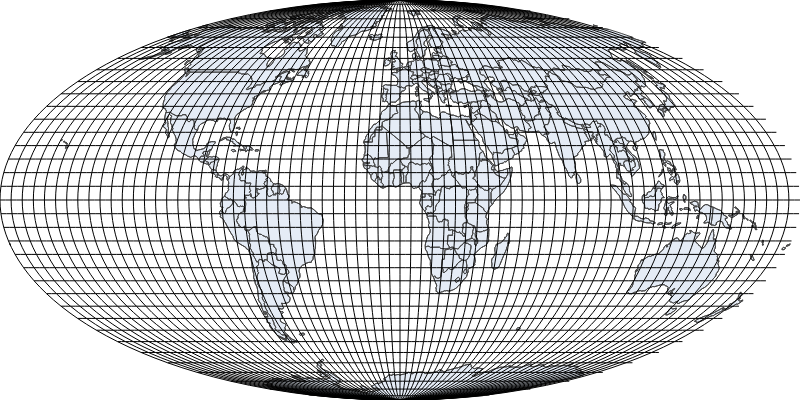

In [6]:
#| echo: false
#| label: fig-mollweide
#| fig-cap: Mollweide Projection
Image(img_bytes1)

The functions below compute the percentage of the globe's surface contained in each and every 5-by-5 degrees grid box:

In [7]:
#!pip install area
from area import area
from functools import partial

def make_polygon(coords, size):
    left_long, bottom_lat = coords
    return np.array([[[left_long, bottom_lat],
                      [left_long, bottom_lat + size],
                      [left_long + size, bottom_lat + size],
                      [left_long + size, bottom_lat],
                      [left_long, bottom_lat]]], dtype=np.float32)

def surface_polygons(grid_size=5):
    long, lat = np.meshgrid(np.arange(-180, 180, grid_size), 
                            np.arange(90-grid_size, -90-grid_size, -grid_size))
    coords = np.dstack([long, lat])
    polygons = np.apply_along_axis(func1d=partial(make_polygon, size=grid_size), 
                                   axis=2, arr=coords)
    return polygons

def surface_area(polygons, perc=True):
    meridian_surface_area = np.array(list(map(area, 
                            map(lambda c: {'type': 'Polygon', 'coordinates': c.tolist()}, 
                            polygons[:, 0]))))/1e6
    surface_area = np.tile(meridian_surface_area.reshape(-1, 1), polygons.shape[1])
    surface_perc = (surface_area / surface_area.sum())
    return surface_perc if perc else surface_area


In [8]:
#| code-fold: false
polygons = surface_polygons(grid_size=5)
surface_perc = surface_area(polygons, perc=True)

The same result can be achieve using a simple cosine function over the latitudes at the center of each grid box, referred by NOAA as [cosine weighting](https://www.ncei.noaa.gov/access/monitoring/ghcn-gridded-products/global-average):

In [9]:
#| code-fold: false
lat = np.linspace(-87.5, 87.5, 36)
cosines = np.cos(lat/180*np.pi)
cosines = cosines/(72*cosines.sum())

Text(0.5, 1.0, 'Surface area of a 5-by-5 degrees grid box')

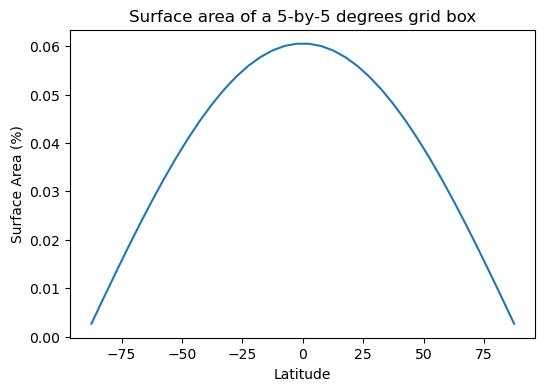

In [10]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lat, cosines*100)
ax.set_xlabel('Latitude')
ax.set_ylabel('Surface Area (%)')
ax.set_title('Surface area of a 5-by-5 degrees grid box')

# Temperature Anomalies

Now we can compute the average global anomaly weighted by the surface area of the grid boxes, not counting missing data.

In [11]:
def surface_stat(data, surface_perc, stat='mean'):
    # Average anomaly weighted by surface area, not counting missing data
    data_mean = np.array([np.nansum(ev * surface_perc) / 
                          (~np.isnan(ev) * surface_perc).sum() 
                          for ev in data])
    if stat == 'mean':
        return data_mean
    elif stat == 'std':
        data_var = [np.nansum((ev - ev_mean) ** 2 * surface_perc) / 
                              (~np.isnan(ev) * surface_perc).sum() 
                    for ev, ev_mean in zip(data, data_mean)]
        return np.sqrt(data_var)

These are the average global anomalies with respect to the 1971-2000 average:

In [12]:
avg_temp = surface_stat(griddedy, surface_perc)
avg_temp

array([-0.49950845, -0.437659  , -0.46099328, -0.55762834, -0.66325144,
       -0.55927735, -0.5296677 , -0.61390813, -0.52221157, -0.41688996,
       -0.64482477, -0.61349774, -0.65583242, -0.69150886, -0.65121656,
       -0.62195114, -0.44614686, -0.42208863, -0.61661892, -0.52107259,
       -0.39073078, -0.46883892, -0.62728571, -0.72594027, -0.76846173,
       -0.64734485, -0.55134399, -0.72619441, -0.76130973, -0.72785092,
       -0.69972305, -0.75875122, -0.66646819, -0.64330766, -0.47295105,
       -0.40953497, -0.64000969, -0.71576234, -0.65454381, -0.57661185,
       -0.55576413, -0.46010078, -0.54557568, -0.56007732, -0.5460153 ,
       -0.49508586, -0.37550539, -0.48066778, -0.49368916, -0.63079376,
       -0.40662835, -0.3620246 , -0.43417767, -0.55512125, -0.40984992,
       -0.45844197, -0.42133779, -0.31418626, -0.31750286, -0.2998834 ,
       -0.17384875, -0.0441839 , -0.19072324, -0.20550301, -0.03651162,
       -0.14753947, -0.29445738, -0.3460578 , -0.35940049, -0.36

::: {.callout-note} 
Note: if you compute the average from 1971 to 2000 (`avg_temp[91:120].mean()`) it won't result in exactly **zero** as one would expect, but **-0.0518** degrees instead. Unfortunately, I couldn't figure out why this is the case in NOAA's data.
:::

In [13]:
#| code-fold: false
avg_temp[91:120].mean()

-0.05189353308685528

Apart from this minor difference, the choice of window for taking the average against which the global anomaly is computed is arbitrary. As mentioned in the motivation, this is my **pet peeve** because it makes particularly difficult to make a point if the baseline is constantly changing.

As you can see in the plots below, changing from 1971-2000 to 1981-2010, for example, only changes the **y axis**: the whole plot shifts down about **0.18 degrees**, but any **difference between two points in the plot remain exactly the same**.

::: {.callout-important}
So, **it doesn't matter which baseline is used**, the difference in global temperature between 2021 and 1880 is the same: **1.02 degrees**.
:::

::: {.callout-tip}
Nonetheless, it would be very helpful to have an absolute measure of the changes in temperature over time. And that's what we're trying to accomplish here.
:::

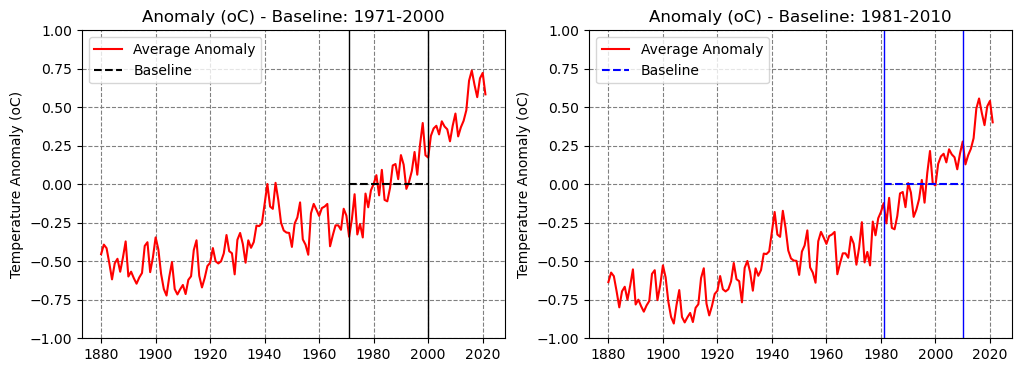

In [14]:
#| echo: false
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_avg(avg_temp, ax=axs[0])
plot_avg(avg_temp, ax=axs[1], start=1981, end=2010, c='b')

However, the averages do not tell the whole story. It is much more interesting to look at the temperature anomalies recorded on each and every grid box.

In [15]:
year_ini = 2021
year_end = 2021
fig = plot_projection(griddedy[year_ini-1880:year_end-1880+1], 
                      seq_offset=year_ini, 
                      add_line=True, animate=True, 
                      colorscale='Jet', colorbar_title='oC', 
                      zmin=-4, zmax=4)

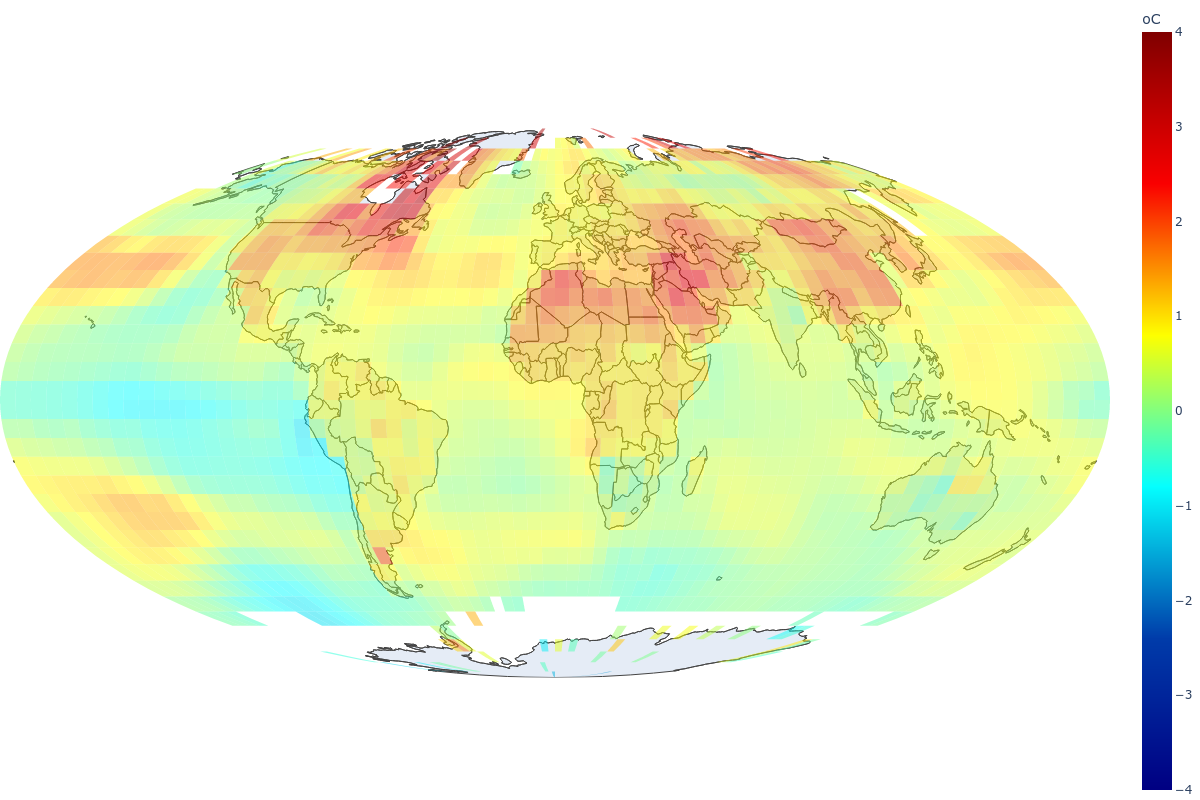

In [16]:
#| echo: false
img_bytes = fig.to_image(format="png", width=1200, height=800)
Image(img_bytes)

The plot above isn't interactive, but if we look at individual grid boxes, we'll see that many of them have many missing data points. That's totally expected, as data wasn't collected in remote places in the late 19th or early 20th centuries.

# Time Series

Let's take at look at a grid box close to Antarctica. Its measurements started in the late 1950s, and there are some years missing.

In [17]:
gy, gx = 33, 69
fig = plot_evolution(griddedy, gy, gx)

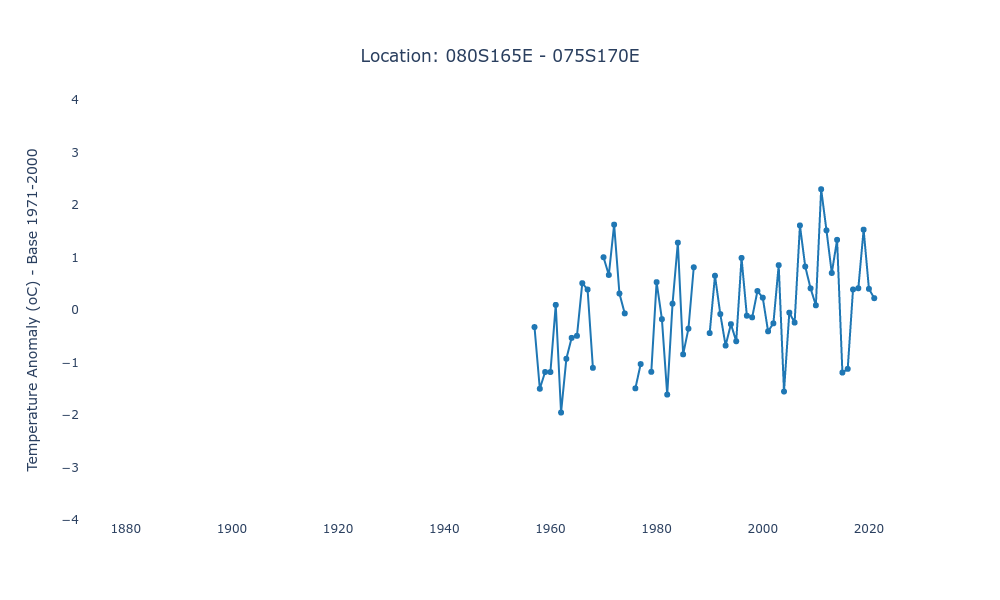

In [18]:
#| echo: false
img_bytes = fig.to_image(format="png", width=1000, height=600)
Image(img_bytes)

# Missing Data Imputation

The first step we need to take is to impute *some* of the missing data. We'll use some simple linear interpolation, but only in those cases where the **gap** in the data isn't too long.

This is the Numpy array corresponding to the plot above:

In [19]:
signal = griddedy[:, gy, gx]
signal

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

Apart from the first 77 years, where there were no measurements whatsoever, there are only five missing measurements: three of those are single years, and the other two are consecutive years.

We obviously cannot do anything about the first 77 years, but we can use linear interpolation to fill in the other five missing points. The function below, `bounds()`, returns the first and last indices of a Numpy array that contain the longest sequence of data points that can be used as base for the imputation.

In [20]:
def bounds(data, max_contiguous_na=5):
    # Returns the start and end indices of the longest
    # valid sequence, that is, containing up to a given
    # number of contiguous missing points
    
    # Gets the indices of the non-null points
    idxs = np.arange(len(data))[~np.isnan(data)]
    max_size = 0
    max_ini = 0
    size = 1
    ini = 0
    # Calculates the size of the gaps of missing data
    gaps = np.diff(idxs) - 1
    for i, v in enumerate(gaps):
        # If there's no gap, the size of valid data is increased by 1
        if v == 0:
            size += 1
        # If that's the long sequence of values containing tolerable 
        # gaps then updates max info
        if size > max_size:
            max_size = size
            max_ini = ini
        # If the gaps is larger than tolerable, resets size and init
        if v > max_contiguous_na:
            ini = i + 1
            size = 1
        # If the gap is tolerable, adds one to the size
        # (that means the next idx)
        elif v > 0:
            size += 1
    # Computes the end of the longest sequence
    max_end = max_ini + max_size
    # Returns the start and end indices of the longest sequence
    ini, end = idxs[max_ini], idxs[max_end-1] + 1
    return ini, end

Let's create three dummy arrays to illustrate how the function above works.

In [21]:
#| code-fold: false
dummy1 = np.ones(15)
dummy1[2:5] = np.nan
dummy1, bounds(dummy1)

(array([ 1.,  1., nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.]),
 (0, 15))

That was an easy case: there's only a gap of three consecutive data points (thus below the default threshold of five), so we can use the whole sequence (start=0, end=15) and impute those three values.

In [22]:
#| code-fold: false
dummy2 = np.ones(15)
dummy2[2:8] = np.nan
dummy2, bounds(dummy2)

(array([ 1.,  1., nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,
         1.,  1.]),
 (8, 15))

The second sequence has six consecutive missing points, so they won't be imputed, and we'll only consider the sequence from its 9th data point (index=8).

In [23]:
#| code-fold: false
dummy3 = np.ones(15)
dummy3[2:5] = np.nan
dummy3[8:14] = np.nan
dummy3, bounds(dummy3)

(array([ 1.,  1., nan, nan, nan,  1.,  1.,  1., nan, nan, nan, nan, nan,
        nan,  1.]),
 (0, 8))

The third example is a bit more peculiar, since it has six consecutive missing points towards its end. Therefore, the longest sequence we can use actually ends at the 9th data point (index=8). This is a rather rare occurrence, since most grid boxes have missing data points in earlier years only.

In our real example, we can use the sequence from 1957 up to 2021:

In [24]:
#| code-fold: false
ini, end = bounds(signal, max_contiguous_na=5)
ini, end, signal[ini:end]

(77,
 142,
 array([-0.325     , -1.5       , -1.1808333 , -1.1816666 ,  0.0975    ,
        -1.9533334 , -0.9291666 , -0.53083336, -0.49250007,  0.5108333 ,
         0.39000002, -1.1016666 ,         nan,  1.0050001 ,  0.6675    ,
         1.6266665 ,  0.31416667, -0.06500002,         nan, -1.4924998 ,
        -1.03      ,         nan, -1.1783333 ,  0.5308334 , -0.175     ,
        -1.6116667 ,  0.11999998,  1.2833333 , -0.84583336, -0.355     ,
         0.8141667 ,         nan,         nan, -0.44000006,  0.65250003,
        -0.07750002, -0.6775    , -0.26916668, -0.5958332 ,  0.9916668 ,
        -0.1091666 , -0.14083336,  0.36166668,  0.23416667, -0.40666673,
        -0.25416663,  0.8541667 , -1.5525001 , -0.04999999, -0.23916666,
         1.6108333 ,  0.8275001 ,  0.41333333,  0.08916668,  2.3008335 ,
         1.5166665 ,  0.705     ,  1.3366666 , -1.1916666 , -1.1216667 ,
         0.39083338,  0.4141667 ,  1.5300001 ,  0.40250006,  0.22500002],
       dtype=float32))

The function below, `fill_values()`, uses Scikit-Learn's [`interp1d()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) to impute the missing values in the longest sequence identified by the `bounds()` function:

In [25]:
from scipy import interpolate

def fill_values(data, 
                max_contiguous_na=5, 
                periods_for_extrapolation=5, 
                method='slinear'):
    time = np.arange(len(data))
    signal = data.copy()
    # If there are no valid data points, there's nothing to fill
    if np.all(np.isnan(signal)):
        return signal
    elif np.any(np.isnan(signal)):
        # Gets minimum and maximum values
        minv, maxv = np.nanmin(signal), np.nanmax(signal)
        # Uses only the values in the longest sequence containing no more than
        # a given number of contiguous missing points (5)
        ini, end = bounds(data, max_contiguous_na)
        signal = signal[ini:end]
        
        # Creates a filler function to interpolate the missing values over time
        try:
            filler_func = interpolate.interp1d(time[ini:end][~np.isnan(signal)], 
                                               signal[~np.isnan(signal)], 
                                               kind=method)
        except ValueError:
            return signal
        
        # Passes the time as argument to the filler function
        filled = filler_func(time[ini:end])
        # Caps interpolated values at actually observed min and max values
        filled = np.minimum(filled, maxv)
        filled = np.maximum(filled, minv)
        if ini > 0:
            # Rebuilds the full sized array, if the longest sequence 
            # doesn't start at zero
            filled = np.concatenate([[np.nan] * ini, filled])
        if end < len(data):
            # If the longest sequence ends before the last time period, 
            # extrapolates the last missing values using the average of
            # a given number of periods
            avg = filled[-periods_for_extrapolation:].mean()
            filled = np.concatenate([filled, 
                                     np.nan_to_num(data[end:].copy(), nan=avg)])
        return filled
    else:
        return signal

We can apply the `fill_values()` function to our real example:

In [26]:
#| code-fold: false
fill_values(signal[ini:end])

array([-0.32499999, -1.5       , -1.18083334, -1.18166661,  0.0975    ,
       -1.95333338, -0.92916662, -0.53083336, -0.49250007,  0.51083332,
        0.39000002, -1.10166657, -0.04833323,  1.00500011,  0.66750002,
        1.62666655,  0.31416667, -0.06500002, -0.77874992, -1.49249983,
       -1.02999997, -1.10416663, -1.17833328,  0.53083342, -0.175     ,
       -1.61166668,  0.11999998,  1.2833333 , -0.84583336, -0.35499999,
        0.81416672,  0.39611113, -0.02194446, -0.44000006,  0.65250003,
       -0.07750002, -0.67750001, -0.26916668, -0.59583318,  0.99166679,
       -0.1091666 , -0.14083336,  0.36166668,  0.23416667, -0.40666673,
       -0.25416663,  0.85416669, -1.55250013, -0.04999999, -0.23916666,
        1.61083329,  0.8275001 ,  0.41333333,  0.08916668,  2.30083346,
        1.51666653,  0.70499998,  1.33666658, -1.1916666 , -1.12166667,
        0.39083338,  0.41416669,  1.53000009,  0.40250006,  0.22500002])

Moreover, we can create yet another function, `fill_series()` to apply the `fill_values()` function to the time series of each and every grid box.

In [27]:
def fill_series(gridded, 
                max_contiguous_na=3, 
                periods_for_extrapolation=5,
                method='slinear'):
    # Applies the fill_values function over every grid box
    filled = np.apply_along_axis(func1d=lambda s: fill_values(s, 
                                                              max_contiguous_na, 
                                                              periods_for_extrapolation, 
                                                              method),
                                 arr=gridded.reshape(gridded.shape[0], -1).T,
                                 axis=1)
    filled = filled.T.reshape(gridded.shape)
    return filled

In [28]:
#| code-fold: false
filled = fill_series(griddedy)
filled.shape

(142, 36, 72)

The variable `filled` has the same shape as the gridded data, and it contains imputed values for *some* of the missing points.

Let's visualize our real example, the grid box close to Antarctica:

In [29]:
gy, gx = 33, 69
fig = plot_evolution(griddedy, gy, gx, filled=filled)

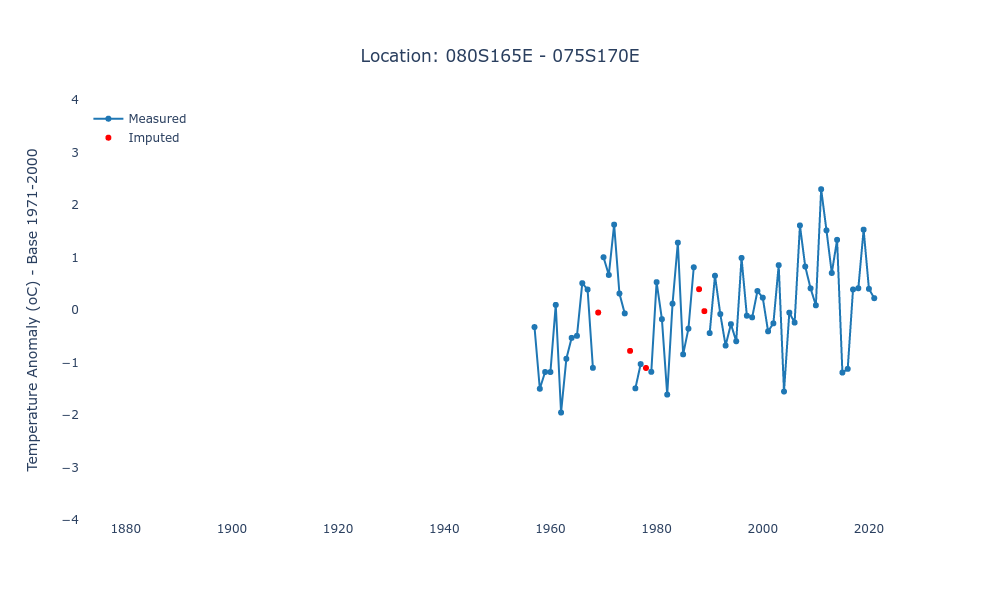

In [30]:
#| echo: false
img_bytes = fig.to_image(format="png", width=1000, height=600)
Image(img_bytes)

Excellent, there are no missing points in this time series anymore.

Now, we can use it to perform **change point detection (CPD)**, our next step.

# Change Point Detection (CPD)

We're using the [ruptures](https://centre-borelli.github.io/ruptures-docs/) package to detect change points in the series of temperature anomalies corresponding to each grid box.

The `change_points()` function detects change points using linearly penalized segmentation ([Pelt](https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/)), having `l1` as the model, and a penalty of three.

In [31]:
#!pip install ruptures
import ruptures as rpt
from ruptures.exceptions import BadSegmentationParameters

def change_points(data, model='l1', pen=3):
    signal = data.copy()
    # If there are no valid data points, returns one regime
    # that starts at 0, ends at the full length, and is nan
    if np.all(np.isnan(signal)):
        return np.array([0, len(signal)]), np.array([np.nan])

    # Gets the index of the first non-missing data
    ini = np.argmax(~np.isnan(signal))

    # Uses the Pelt method of the ruptures package
    # to find regime changes/breaks
    algo = rpt.Pelt(model=model).fit(signal[ini:])
    try:
        breaks = algo.predict(pen=pen)
    except BadSegmentationParameters:
        # If no changes/breaks were found, assumes
        # the regime goes up to the end of the series
        breaks = [len(signal)-ini]

    # Gets the indices of the breaks and 
    breaks = np.array([0, *breaks]) + ini
    # Computes the average of each regime
    averages = np.array([signal[breaks[i-1]:breaks[i]].mean() 
                         for i in range(1, len(breaks))])

    # First regime must be at least 10 years long
    i = np.argmax(np.diff(breaks) >= 10)
    return breaks[i:], averages[i:]

For our real example, we feed the filled time series for the `change_points()` function, and that's the result:

In [32]:
#| code-fold: false
change_points(filled[:, gy, gx])

(array([ 77, 127, 142]), array([-0.23727499,  0.6299445 ], dtype=float32))

It identified one change point,happening in 2007 (index 127). From the start of the series, in 1957 (index 77), up until 2007, the average temperature anomaly was -0.236 degrees. From 2008 on, the new regime has an average temperature anomaly of 0.616 degrees.

We can use this information to construct a time series representing these regimes, and that's what the function below, `change_evolution()`, does:

In [33]:
def change_evolution(changes, offset=True):
    breaks, averages = changes
    # Creates a full series using the break points and using the average
    # of each regime
    avg_series = np.concatenate([[averages[i]] * (breaks[i + 1] - breaks[i]) 
                                 for i in range(len(averages))])
    # If offset, shifts the starting point to zero
    if offset:
        avg_series -= avg_series[0]
    # If the first break is other than zero, concatenates empty data at 
    # the start to make the array full size
    if breaks[0] > 0:
        avg_series = np.concatenate([[np.nan] * breaks[0], avg_series])
    return avg_series

In [34]:
#| code-fold: false
change_evolution(change_points(filled[:, gy, gx]), offset=False)

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

We can also set the `offset` argument to `True` to consider the **first regime as the baseline**, thus computing temperatures with respect to its average instead:

In [35]:
#| code-fold: false
change_evolution(change_points(filled[:, gy, gx]), offset=True)

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In the example above, the second regime exhibits a temperature 0.85 degrees higher than the first, baseline, regime. We'll use this approach to compute the **absolute change in temperature** with respect to the first observed regime (in the example above, the regime between 1957 and 2007).

:::{callout-note}
The quality of the estimated absolute change is limited by the availability of data in earlier years, though. In our example, it could have been the case that, before 1957, there was yet another regime with a possibly lower temperature.

If that were the case, it means that the actual change may have be even higher. Conversely, if that unobserved regime had a higher temperature, the actual change would be lower than our estimation. Given that the latter case is rarely observed in practice, it's rather safe to assume the overall estimation of the absolute change in temperature is actually a lower bound.
:::

Next, we can create two other functions, `series_changes()` and `series_evolution()`, to apply the `change_points()` and `change_evolution()` functions, respectively, to the time series of each and every grid box.

In [36]:
def series_changes(filled, model='l1', pen=3):
    # Applies the change_points function over every filled series
    changes = np.apply_along_axis(func1d=lambda s: change_points(s, model, pen),
                                  arr=filled.reshape(filled.shape[0], -1).T,
                                  axis=1)
    changes = changes.reshape(*filled.shape[1:], 2)
    return changes

In [37]:
def series_evolution(gridded, changes, offset=True, keep_missing=True):
    # Applies the change_evolution function over every grid box
    missing = np.isnan(gridded.reshape(gridded.shape[0], -1).T)
    evolution = np.apply_along_axis(func1d=lambda s: change_evolution(s, offset),
                                    arr=changes.reshape(-1, 2),
                                    axis=1)
    if keep_missing:
        evolution[missing] = np.nan
    evolution = evolution.T.reshape(gridded.shape)
    return evolution

In [38]:
#| code-fold: false
model = 'l1'
pen = 3
changes = series_changes(filled, model=model, pen=pen)
regimes = series_evolution(griddedy, changes, keep_missing=True)
regimes.shape

/home/dvgodoy/anaconda3/envs/warming/lib/python3.8/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/home/dvgodoy/anaconda3/envs/warming/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



(142, 36, 72)

As expected, the `regimes` variable has the same shape as both `filled` and `griddedy`, representing one time series for each grid box.

Let's visualize the regimes for our grid box close to Antarctica:

In [39]:
gy, gx = 33, 69
fig = plot_evolution(griddedy, gy, gx, 
                     filled=filled, changes=changes, regime=regimes)

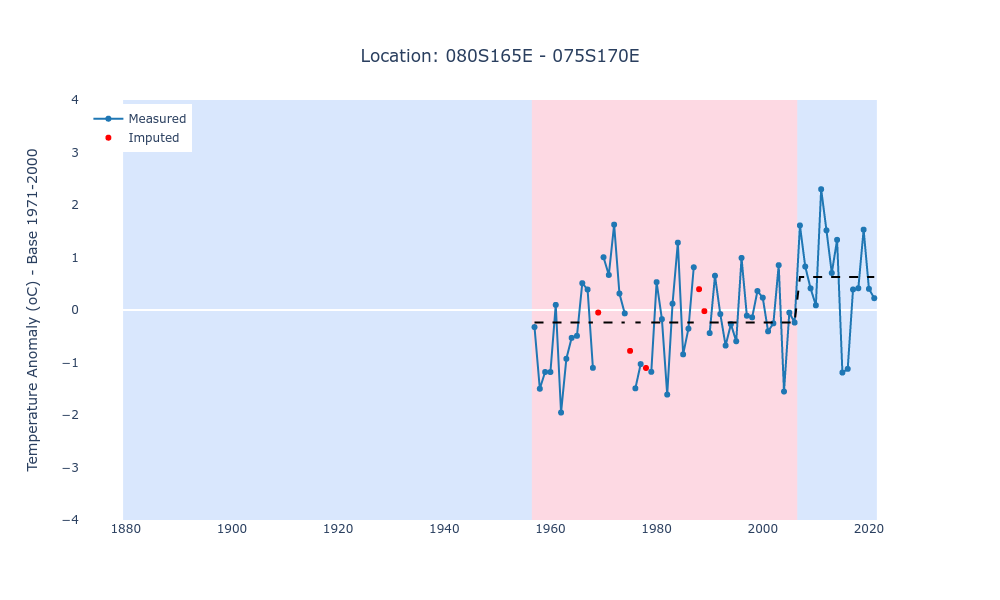

In [40]:
#| echo: false
img_bytes = fig.to_image(format="png", width=1000, height=600)
Image(img_bytes)

# Absolute Changes in Temperature

Since we have time series of the estimated regimes, we can use them to compute a global average of the absolute change in temperature weighted by the surface area of each grid box.

In [41]:
#| code-fold: false
avg_temp_regimes = surface_stat(regimes, surface_perc)
avg_temp_regimes

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00863404, 0.00869392, 0.0095288 , 0.00935041, 0.00905566,
       0.02286673, 0.02684635, 0.0284382 , 0.02915019, 0.03008991,
       0.03348921, 0.03161973, 0.03078799, 0.03283298, 0.03250496,
       0.03158139, 0.03060249, 0.02906777, 0.02820625, 0.02559448,
       0.02694036, 0.0305054 , 0.03330137, 0.03123806, 0.03423738,
       0.04043984, 0.0452272 , 0.0449563 , 0.04931425, 0.05106176,
       0.06527432, 0.06554802, 0.06675241, 0.07094976, 0.07198512,
       0.09538307, 0.101054  , 0.10183483, 0.10148122, 0.10393017,
       0.13250359, 0.13293051, 0.13482252, 0.13729236, 0.14118601,
       0.16000189, 0.16481473, 0.16978522, 0.18086563, 0.19344881,
       0.22351007, 0.22546735, 0.22649203, 0.24322801, 0.22974729,
       0.23892152, 0.24470963, 0.21670845, 0.2101918 , 0.20486365,
       0.20398545, 0.20527823, 0.20239556, 0.20231018, 0.20308

It was only in the 11th year of the series (1890), that there was a regime change somewhere in the globe. Let's visualize the data in a plot:

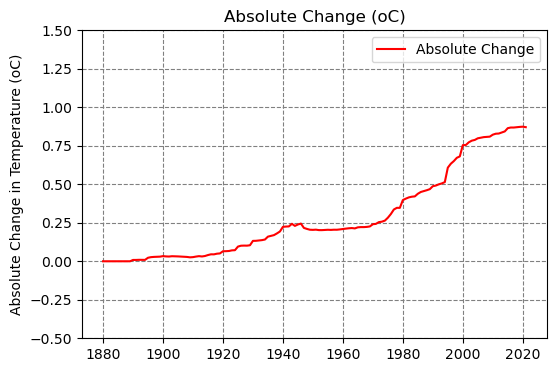

In [42]:
#| echo: false
plot_avg2(avg_temp_regimes)

The change in temperature in the 90s is particularly striking!

Finally, let's take a look at these absolute changes in temperature across the globe in 2021:

In [43]:
year_ini = 2021
year_end = 2021
fig = plot_projection(regimes[year_ini-1880:year_end-1880+1], 
                      seq_offset=year_ini, 
                      add_line=True, animate=True, 
                      colorscale='Jet', colorbar_title='oC', 
                      zmin=-4, zmax=4)

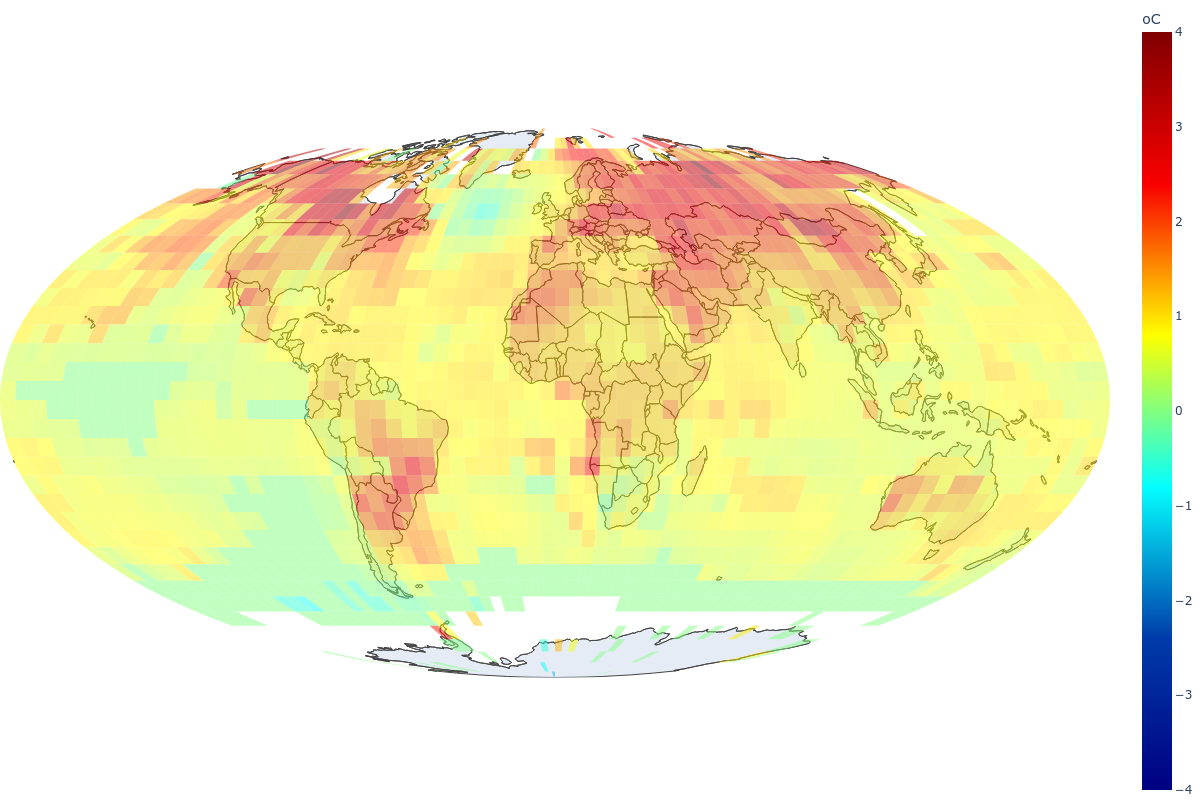

In [44]:
#| echo: false
img_bytes = fig.to_image(format="png", width=1200, height=800)
Image(img_bytes)

Many regions in the northern hemisphere show regimes that are **3 degrees Celsius or more** above their corresponding (observed) first regime since 1880.

To explore the evolution over time, simply select **`Absolute`** in the interactive plot in the main page of [Heating Planet](https://heatingplanet.org).

::: {.callout-tip}
While exploring the interactive plot, pay attention to how some areas heat up earlier than others, and how warmer regions spread over time.
:::

Did you notice that the landmasses are getting warmer than the oceans? Let's dig deeper into it!

# Over Land and Sea

First, we need to define a mask for our grid cells, a Numpy array indicating those grid cells which have more than 50% of its area as landmass (one indicates land, zero indicates sea). I've prepared this array and saved it in the `land.npy` file.

In [64]:
import io

response = requests.get('https://heatingplanet.org/assets/data/land.npy')
response.raise_for_status()
land_mask = np.load(io.BytesIO(response.content))

## Anomalies

Now we can make deep copies of the anomalies (`griddedy`)  and use the land_mask variable to mask either landmasses or oceans. This allows us to compute the average global anomalies over land and sea, separately, using the `surface_stat` function once again. Let's see what are the current figures for 2021:

In [66]:
from copy import deepcopy

griddedy_land = deepcopy(griddedy)
griddedy_sea = deepcopy(griddedy)
griddedy_land[:, land_mask==0] = np.nan
griddedy_sea[:, land_mask==1] = np.nan

In [67]:
avg_temp_land = surface_stat(griddedy_land, surface_perc)
avg_temp_sea = surface_stat(griddedy_sea, surface_perc)
avg_temp_land[-1], avg_temp_sea[-1]

(0.9967666810102901, 0.3257011776518976)

The average global temperature anomaly over land is roughly 1° Celsius while the seas warmed roughly 0.3° Celsius. We can see the evolution of these figures over time in the plots below:

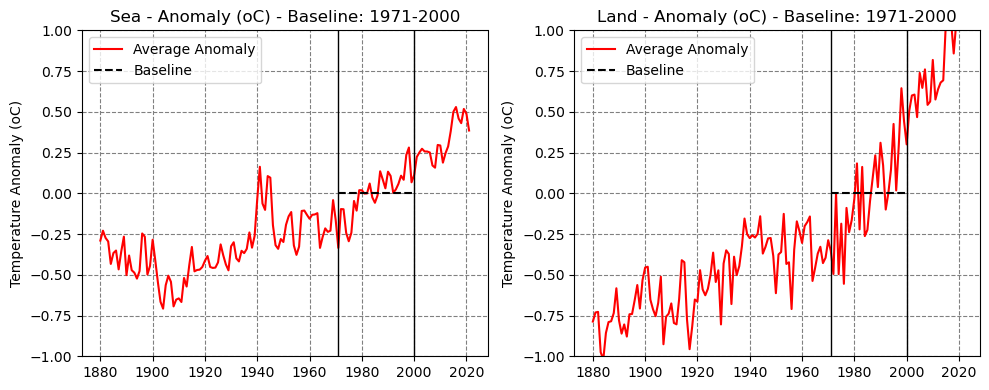

In [57]:
#| echo: false
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_avg(avg_temp_sea, ax=axs[0])
plot_avg(avg_temp_land, ax=axs[1])
axs[0].set_title(f'Sea - {axs[0].title.get_text()}')
axs[1].set_title(f'Land - {axs[1].title.get_text()}')
fig.tight_layout()

Clearly, there's a much steeper trend in the rise of temperature over landmasses.

What about the absolute change in temperature?

## Absolute Changes

We can apply the same mask to the absolute changes we've previously computed (`regimes`) and, once again, compute the global averages:

In [51]:
regimes_land = deepcopy(regimes)
regimes_sea = deepcopy(regimes)
regimes_land[:, land_mask==0] = np.nan
regimes_sea[:, land_mask==1] = np.nan

In [53]:
avg_temp_regimes_land = surface_stat(regimes_land, surface_perc)
avg_temp_regimes_sea = surface_stat(regimes_sea, surface_perc)
avg_temp_regimes_land[-1], avg_temp_regimes_sea[-1]

(1.4010793734655795, 0.625477496613651)

In 2021, the last data point in our series, landmasses are 1.4° Celsius warmer than they were in 1880 while the oceans are roughly 0.6° Celsius warmer. We can see the evolution of these figures over time in the plots below:

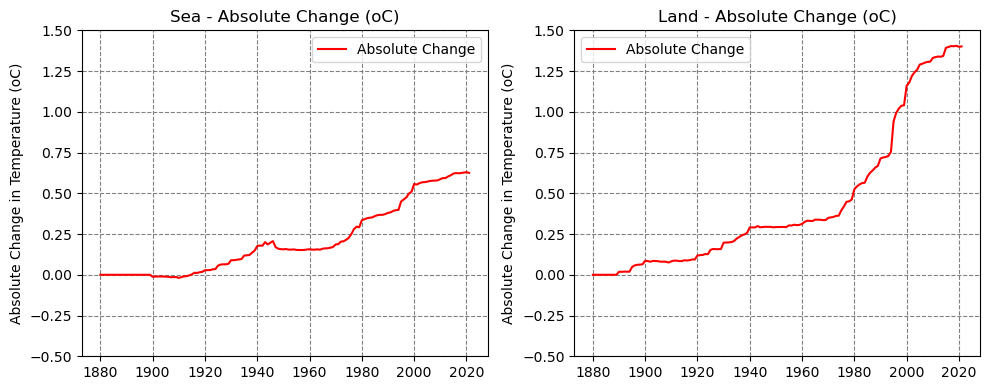

In [59]:
#| echo: false
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_avg2(avg_temp_regimes_sea, ax=axs[0])
plot_avg2(avg_temp_regimes_land, ax=axs[1])
axs[0].set_title(f'Sea - {axs[0].title.get_text()}')
axs[1].set_title(f'Land - {axs[1].title.get_text()}')
fig.tight_layout()

It's particularly striking the rise in temperature over land in the 1980s, 1990s, and early 2000s. In the 1990s, especially, we see both land and sea warming really fast.

# Saving to File

The interactive plot in the main page uses two `.dat` files (`zvalues` and `evolution`) containing the raw data from NOAA, the estimated regimes we discussed above, and the imputed data points.

The code below generates these two files.

In [55]:
#| echo: false
from array import array

def save2dat(series_data, filename, swap=False, nan=-999):
    if not isinstance(series_data, list):
        series_data = [series_data, ]
    n_series = len(series_data)
    with open(f"{filename}.dat", "wb") as newFile:
        data = [nan, n_series]
        tot_len = len(data)
        for i in range(n_series):
            data += [series_data[i].ndim] + list(series_data[i].shape)
            tot_len += 1 + series_data[i].ndim + 2
            nitems = np.prod(series_data[i].shape)
            data += [tot_len, nitems]
            data += np.nan_to_num(series_data[i], nan=nan).flatten().tolist()
            tot_len += nitems
        float_array = array('f', data)
        if swap:
            float_array.byteswap()
        float_array.tofile(newFile)


def dat2array(fname):
    with open(f'{fname}.dat', 'rb') as f:
        dat = array('f')
        dat.fromfile(f, 3)
        nanvalue, nseries, ndims = dat.tolist()
        shapes = []
        starts = []
        lens = []
        for i in range(int(nseries)):
            dat.fromfile(f, int(ndims)+2)
            shapes.append(np.array(dat.tolist()[-int(ndims)-2:-2]).astype(int))
            starts.append(int(dat.tolist()[-2]))
            lens.append(int(dat.tolist()[-1]))
            dat.fromfile(f, lens[-1])
            try:
                dat.fromfile(f, 1)
                ndims = dat[-1]
            except EOFError:
                pass
        arr = np.array(dat.tolist())
        return [arr[starts[i]:starts[i]+lens[i]].reshape(shapes[i])
                for i in range(int(nseries))]

In [56]:
# filled series -> array
n_years = griddedy.shape[0]
filled_locs, filled_years = np.where(np.isnan(griddedy.reshape(n_years, -1).T) 
                                     & ~np.isnan(filled.reshape(n_years, -1).T))
filled_vals = filled.reshape(n_years, -1).T[filled_locs, filled_years]
filled_arrays = np.array([filled_locs, filled_years, filled_vals])

# changes -> array
idxs_breaks = np.cumsum(list(map(len, changes[:, :, 0].reshape(-1))))
vals_breaks = np.array([v for s in changes[:, :, 0].reshape(-1, ) 
                        for v in s])
vals_avgs = np.array([v for s in changes[:, :, 1].reshape(-1, ) 
                      for v in np.concatenate([[np.nan], s])])
chg_arrays = np.zeros(shape=(3, vals_breaks.shape[0])) * np.nan
chg_arrays[0, :idxs_breaks.shape[0]] = idxs_breaks
chg_arrays[1] = vals_breaks
chg_arrays[2] = vals_avgs

save2dat([griddedy, regimes], 'zvalues', swap=False, nan=-999)
save2dat([filled_arrays, chg_arrays], 'evolution', swap=False)